## Installing needed libraries
Restart kernel after installation

In [ ]:
!pip install transformers
!pip install tensorflow-text

     |████████████████████████████████| 3.5 MB 5.5 MB/s 
     |████████████████████████████████| 6.8 MB 31.8 MB/s 
     |████████████████████████████████| 67 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 44.3 MB/s 
     |████████████████████████████████| 895 kB 42.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 4.9 MB 4.3 MB/s 
     |████████████████████████████████| 462 kB 40.6 MB/s 


## Imports
Next, we need to import all the needed libraries

In [ ]:
import random
import keras
import tensorflow_text
import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import backend as K
import pandas as pd
import numpy as np
import tensorflow as tf

## Reading the data 
We read the main dataset from the imported csv file.

In [ ]:
data = pd.read_csv("http://modelingcreativity.org/data/aut_categorizedRaters.csv", encoding = 'latin-1')

In [ ]:
data.head()

,research_id,response_id,respondent_id,object,original_response,cleaned_response,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63
0,CES201610,10063.0,648,brick,aambeeld,aambeeld,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,CES201610,5801.0,363,brick,het aanleggen van een weg,aanleggen weg,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CES201610,3973.0,237,brick,aannemen,aannemen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,CES201610,5226.0,300,brick,aannemer,aannemer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,CES201610,8321.0,555,brick,aarde,aarde,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We read the data from the raters' files.

In [ ]:
raters_1 = pd.read_csv('http://modelingcreativity.org/data/brickcat_rater1.csv', encoding = 'latin-1').drop_duplicates(['cleaned_response'])
responses_1 = raters_1['cleaned_response'].to_list()
targets_1 = np.array([raters_1["cat_"+str(i)].to_list() for i in range(64)]).T

In [ ]:
raters_2 = pd.read_csv('http://modelingcreativity.org/data/brickcat_rater2.csv', encoding = 'latin-1').drop_duplicates(['cleaned_response'])
responses_2 = raters_2['cleaned_response'].to_list()
targets_2 = np.array([raters_2["cat_"+str(i)].to_list() for i in range(64)]).T

In [ ]:
raters_3 = pd.read_csv('http://modelingcreativity.org/data/brickcat_rater3.csv', encoding = 'latin-1').drop_duplicates(['cleaned_response'])
responses_3 = raters_3['cleaned_response'].to_list()
targets_3 = np.array([raters_3["cat_"+str(i)].to_list() for i in range(64)]).T

In [ ]:
len(responses_1)

473

Extract only the responses that are not in the raters' datasets to feed into the algorithm.

In [ ]:
remaining_data = data[~data['cleaned_response'].isin(responses_1+responses_2+responses_3).to_numpy()]

In [ ]:
remaining_data.shape

(3880, 70)

In [ ]:
responses = remaining_data['cleaned_response'].to_list()
categories = np.array([remaining_data["C"+str(i)].to_list() for i in range(64)]).T

In [ ]:
## This can be used instead if you don't want to remove any of the responses from the main dataframe
#responses = data['cleaned_response'].to_list()
#categories = np.array([data["C"+str(i)].to_list() for i in range(64)]).T

In [ ]:
len(responses)
#remaining number of responses to be used

3880

## Loading the model and generating embeddings

In [ ]:
module     = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3')

embeddings = module(responses)

In [ ]:
X = embeddings.numpy()
y = categories

## Saving embeddings to disk



In [ ]:
np.save('X',X)
np.save('y',y)

In [ ]:
X = np.load('X.npy')
y = np.load('y.npy')

In [ ]:
X.shape,y.shape

((3880, 512), (3880, 64))

## Train test split

Divide into training (90%) and testing (10%) set, so that we have a set to test the final model's unbiased performance. The training set is further divided into a training (90%) and validation (10%) set to find the best model. We shuffle the data to get a random split, and also set a seed for reproducability.

In [ ]:
X_interm, X_test, y_interm, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_interm, y_interm, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((3142, 512), (350, 512), (388, 512))

## Training a simple neural network

### Defining metrics

Create an f1 score function to add as a metric to the keras NN, as it is not available by default.

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



### Training parameters

In [ ]:
LEARNING_RATE = 0.1 #@param {type:"number"}
BATCH_SIZE = 256 #@param {type:"integer"}
EPOCHS = 40 #@param {type:"integer"}

### Defining model

In [ ]:
def model_function ():
  global LEARNING_RATE
  inputs = Input(shape=(512,), name='inputs', dtype='float')
  output = Dense(64, activation = 'sigmoid')(inputs)
  model = Model(inputs= inputs, outputs=output, name='USE_MultiLabel')
  model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(LEARNING_RATE), metrics=['categorical_accuracy',f1])
  return model

### Train look

In [ ]:
model = model_function ()
history = model.fit(X_train,y_train, validation_data = (X_val, y_val), epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/40
13/13 [==============================] - 1s 24ms/step - loss: 0.1482 - categorical_accuracy: 0.3339 - f1: 0.3210 - val_loss: 0.0585 - val_categorical_accuracy: 0.4829 - val_f1: 0.4566
Epoch 2/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0566 - categorical_accuracy: 0.5255 - f1: 0.5291 - val_loss: 0.0484 - val_categorical_accuracy: 0.5771 - val_f1: 0.6054
Epoch 3/40
13/13 [==============================] - 0s 8ms/step - loss: 0.0445 - categorical_accuracy: 0.6318 - f1: 0.6224 - val_loss: 0.0396 - val_categorical_accuracy: 0.6486 - val_f1: 0.6302
Epoch 4/40
13/13 [==============================] - 0s 7ms/step - loss: 0.0360 - categorical_accuracy: 0.6989 - f1: 0.6778 - val_loss: 0.0329 - val_categorical_accuracy: 0.7371 - val_f1: 0.6842
Epoch 5/40
13/13 [==============================] - 0s 7ms/step - loss: 0.0307 - categorical_accuracy: 0.7387 - f1: 0.7153 - val_loss: 0.0301 - val_categorical_accuracy: 0.7514 - val_f1: 0.7184
Epoch 6/40
13/13 [===========

## Visualization of results

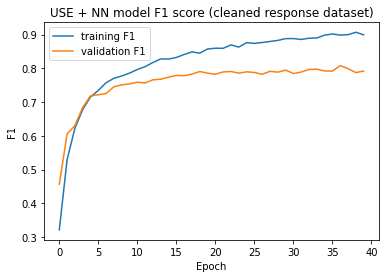

In [ ]:
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('USE + NN model F1 score (cleaned response dataset)')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['training F1', 'validation F1'], loc='upper left')
plt.show()

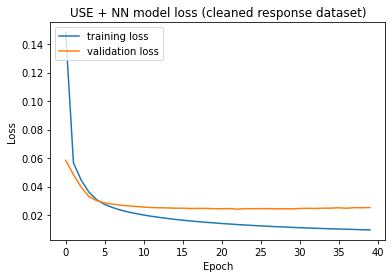

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('USE + NN model loss (cleaned response dataset)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.show()

## Evaluation on the validation set


In [ ]:
predictions = model.predict(X_val)
predictions = (predictions > 0.5)
accuracy   = accuracy_score(y_val, predictions)
precision  = precision_score(y_val, predictions, average = 'micro')
recall     = recall_score(y_val, predictions, average = 'micro')
f1_        = f1_score(y_val, predictions, average = 'micro')
hl         = hamming_loss(y_val, predictions)

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F-1:", round(f1_, 3))
print("Hamming Loss:", round(hl, 5))

Accuracy: 0.72
Precision: 0.85
Recall: 0.745
F-1: 0.794
Hamming Loss: 0.00656


## Evaluation on the test set


In [ ]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5) 

accuracy   = accuracy_score(y_test, predictions)
precision  = precision_score(y_test, predictions, average = 'micro')
recall     = recall_score(y_test, predictions, average = 'micro')
f1_        = f1_score(y_test, predictions, average = 'micro')
hl         = hamming_loss(y_test, predictions)

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F-1:", round(f1_, 3))
print("Hamming Loss:", round(hl, 5))

Accuracy: 0.709
Precision: 0.836
Recall: 0.7
F-1: 0.762
Hamming Loss: 0.00769


In [ ]:
## Print the precision, recall, and f1-score for each category (0 to 63)
test_report = metrics.classification_report(y_test, predictions, digits=3)
print(test_report)

              precision    recall  f1-score   support

           0      0.786     0.759     0.772        29
           1      0.944     0.958     0.951       142
           2      1.000     1.000     1.000         5
           3      1.000     0.500     0.667         2
           4      1.000     0.333     0.500         3
           5      0.900     0.900     0.900        20
           6      0.143     0.200     0.167         5
           7      0.833     0.625     0.714         8
           8      0.000     0.000     0.000         0
           9      0.500     0.500     0.500         2
          10      0.500     0.500     0.500         2
          11      0.769     0.476     0.588        21
          12      0.000     0.000     0.000         0
          13      0.250     0.222     0.235         9
          14      1.000     1.000     1.000         2
          15      1.000     0.500     0.667         2
          16      0.000     0.000     0.000         1
          17      0.750    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


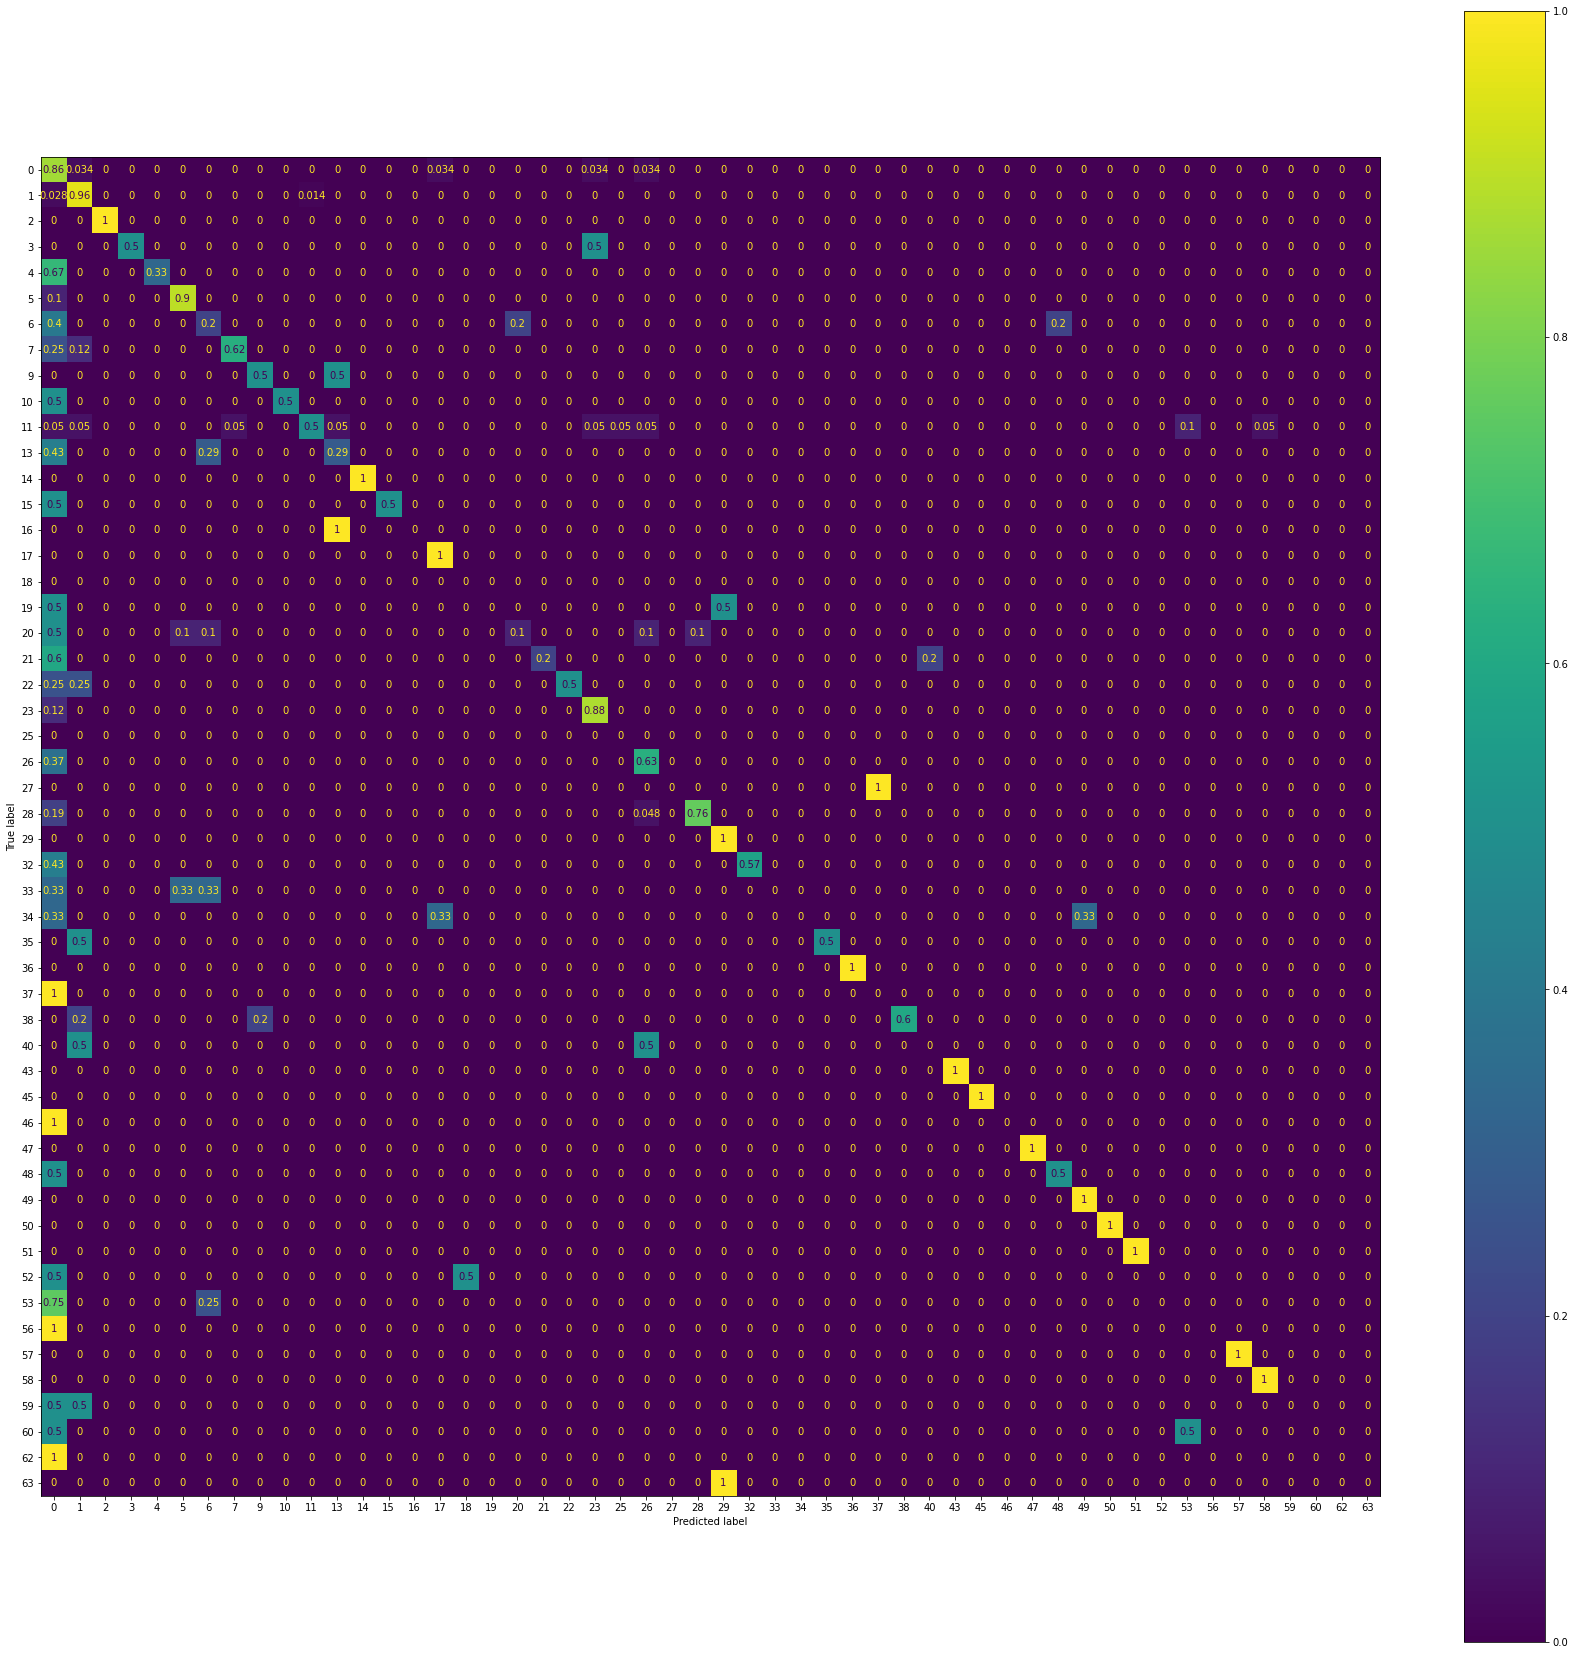

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
cm = metrics.ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), predictions.argmax(axis=1), ax=ax, normalize = 'true')

## Rater vs Rater Comparison

Hamming loss scores for all raters between each other.


In [ ]:
# Rater 1 vs Rater 2
rater01_02   = hamming_loss(targets_1, targets_2)

# Rater 1 vs Rater 3
rater01_03   = hamming_loss(targets_1, targets_3)

# Rater 2 vs Rater 3
rater02_03   = hamming_loss(targets_2, targets_3)

print("Rater 1 vs Rater 2:")
print("Hamming Loss:", round(rater01_02, 5))
print()
print("Rater 1 vs Rater 3:")
print("Hamming Loss:", round(rater01_03, 5))
print()
print("Rater 2 vs Rater 3:")
print("Hamming Loss:", round(rater02_03, 5))


Rater 1 vs Rater 2:
Hamming Loss: 0.02801

Rater 1 vs Rater 3:
Hamming Loss: 0.0291

Rater 2 vs Rater 3:
Hamming Loss: 0.02778


## Rater vs USE + NN Algorithm

Evaluation of the USE + NN algorithm using predictions based on the raters' sets. Hamming loss scores between each rater's category codings and the algorithm predictions of the categories based on the responses in the raters' files are extracted.

In [ ]:
embeddings_1 = module(responses_1)
embeddings_2 = module(responses_2)
embeddings_3 = module(responses_3)

In [ ]:
predictions_1 = model.predict(embeddings_1.numpy())
predictions_1 = (predictions_1 > 0.5) 

predictions_2 = model.predict(embeddings_2.numpy())
predictions_2 = (predictions_2 > 0.5) 

predictions_3 = model.predict(embeddings_3.numpy())
predictions_3 = (predictions_3 > 0.5) 

In [ ]:
# Rater 1 vs Algorithm
rater01_hl = hamming_loss(targets_1, predictions_1)

# Rater 1 vs Algorithm
rater02_hl = hamming_loss(targets_2, predictions_2)

# Rater 3 vs Algorithm
rater03_hl = hamming_loss(targets_3, predictions_3)


print("Rater 1 vs Algorithm:", round(rater01_hl, 5))
print("Rater 2 vs Algorithm:", round(rater02_hl, 5))
print("Rater 3 vs Algorithm:", round(rater03_hl, 5))

Rater 1 vs Algorithm: 0.03211
Rater 2 vs Algorithm: 0.02861
Rater 3 vs Algorithm: 0.02679
